In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

<ipython-input-56-ca8cb3823380>:14: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [57]:
image_data = np.load('/content/drive/MyDrive/Biometrics_MiniProject/2D/image_data.npy');
labels = np.load('/content/drive/MyDrive/Biometrics_MiniProject/2D/labels.npy');

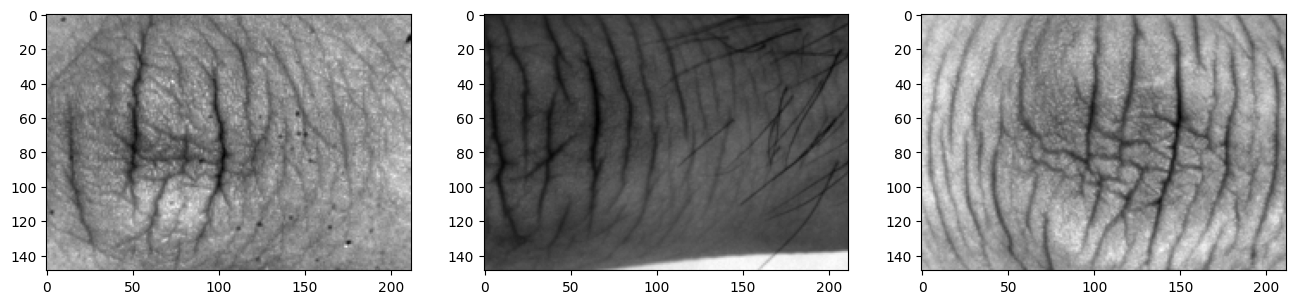

In [65]:
fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1, cmap='gray');
axes[1].imshow(image2, cmap='gray');
axes[2].imshow(image3, cmap='gray');

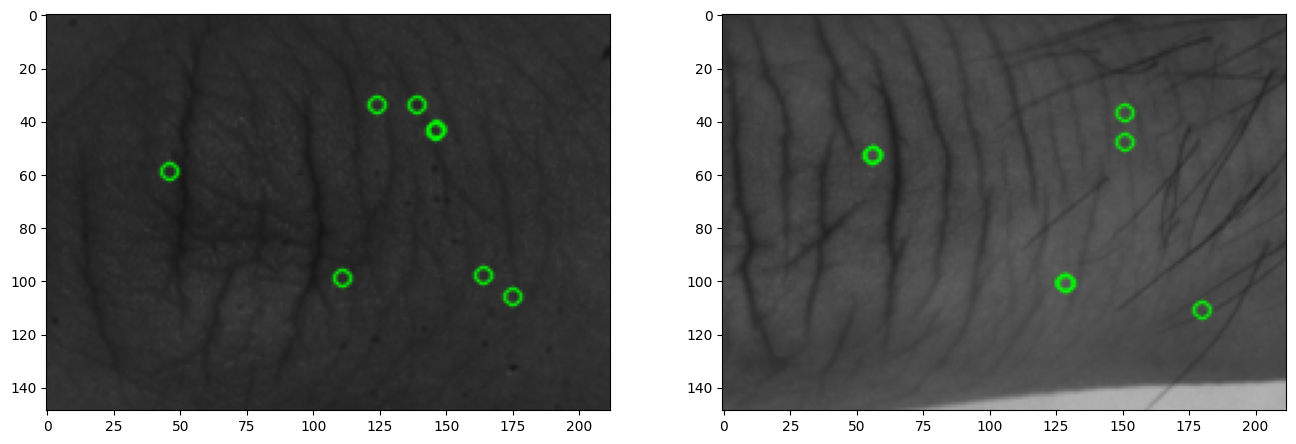

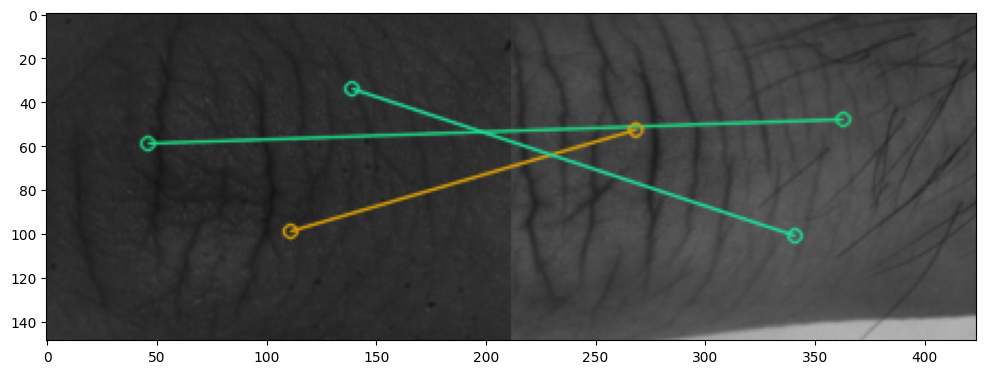

In [59]:
import cv2
import matplotlib.pyplot as plt

gray1 = image_data[0] # Assigning the image as is since its already grayscale
gray2 = image_data[1] # Assigning the image as is since its already grayscale


# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB in both images
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)


image1_keypoints = cv2.drawKeypoints(cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR), keypoints1, None, color=(0,255,0), flags=0)
image2_keypoints = cv2.drawKeypoints(cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR), keypoints2, None, color=(0,255,0), flags=0)

# Plot the images with keypoints
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(image1_keypoints)  # Image 1 with keypoints
axes[1].imshow(image2_keypoints)  # Image 2 with keypoints
plt.show()


bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)


matches = sorted(matches, key=lambda x: x.distance)

matched_image = cv2.drawMatches(cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR), keypoints1, cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR), keypoints2, matches[:10], None, flags=2)

plt.figure(figsize=(12, 12))
plt.imshow(matched_image)
plt.show()

<ipython-input-60-1a5c98e047a9>:2: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(gray, sigma=sigma, order='rc')


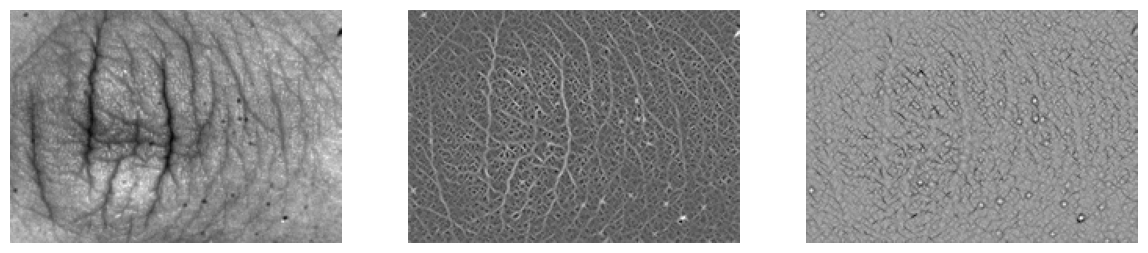

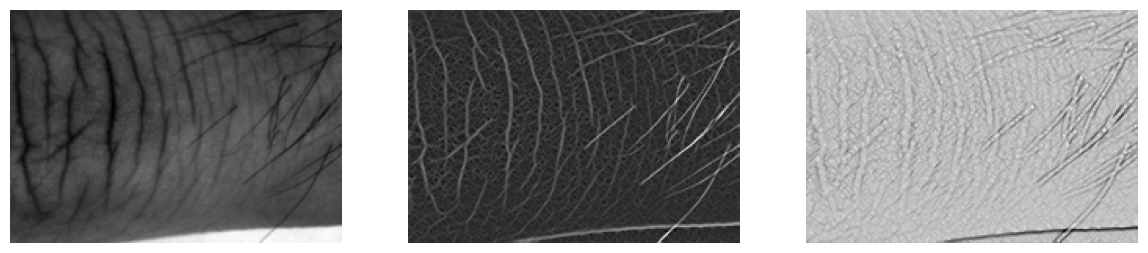

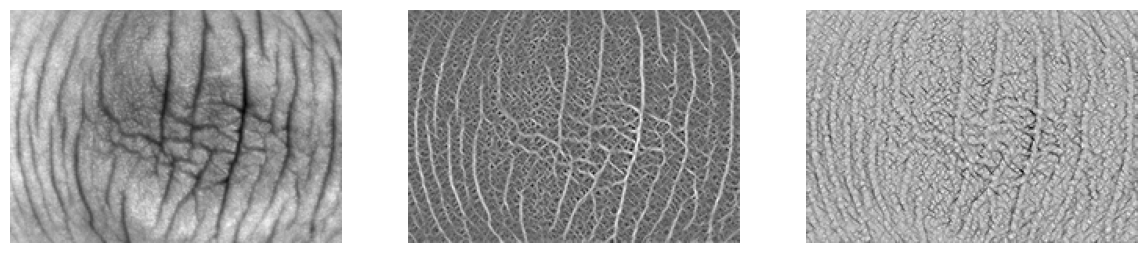

In [60]:
def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (12,12))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

a, b = detect_ridges(image1, sigma=0.15)
plot_images(image1, a, b)

a, b = detect_ridges(image2, sigma=0.15)
plot_images(image2, a, b)

a, b = detect_ridges(image3, sigma=0.15)
plot_images(image3, a, b)

In [81]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

ids = [label for (label, finger) in labels]
unique_labels = np.unique(ids)
encoded_labels = LabelEncoder().fit_transform(ids)
labels_one_hot = to_categorical(encoded_labels, num_classes=228)

print(f"One-hot encoded labels shape: {labels_one_hot.shape}")


One-hot encoded labels shape: (5016, 228)


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels_one_hot, test_size=0.2, random_state=42
)

In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [101]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define model parameters
input_shape = (149, 212, 1)
batch_size = 256
epochs = 100

# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(228, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = create_model()


history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test)
)


Epoch 1/100
15/15 [==============================] - 46s 3s/step - loss: 5.4342 - accuracy: 0.0077 - val_loss: 6.4623 - val_accuracy: 0.0060
Epoch 2/100
15/15 [==============================] - 44s 3s/step - loss: 5.2840 - accuracy: 0.0156 - val_loss: 11.4788 - val_accuracy: 0.0020
Epoch 3/100
15/15 [==============================] - 43s 3s/step - loss: 5.0783 - accuracy: 0.0269 - val_loss: 8.5476 - val_accuracy: 0.0030
Epoch 4/100
15/15 [==============================] - 43s 3s/step - loss: 4.8502 - accuracy: 0.0389 - val_loss: 9.3907 - val_accuracy: 0.0050
Epoch 5/100
15/15 [==============================] - 43s 3s/step - loss: 4.5909 - accuracy: 0.0535 - val_loss: 11.4552 - val_accuracy: 0.0050
Epoch 6/100
15/15 [==============================] - 43s 3s/step - loss: 4.3579 - accuracy: 0.0626 - val_loss: 9.4874 - val_accuracy: 0.0090
Epoch 7/100
15/15 [==============================] - 43s 3s/step - loss: 4.2875 - accuracy: 0.0623 - val_loss: 12.4748 - val_accuracy: 0.0120
Epoch 8/10